In [ ]:
# In this notebook we will examine the pointing data used to build the pointing model on Apr Run. 

## Pointing accuracy

In [1]:
from lsst.pipe.tasks.quickFrameMeasurement import QuickFrameMeasurementTask
from lsst.summit.utils.bestEffort import BestEffortIsr
from lsst.geom import PointD
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import lsst.daf.butler as dafButler

from astropy import units as u 
from astropy.coordinates import SkyCoord, AltAz
from lsst.obs.lsst.translators.latiss import AUXTEL_LOCATION
import lsst.geom as geom

In [2]:
# Call butler
REPO_DIR = '/repo/LATISS'
butler = dafButler.Butler(REPO_DIR, instrument='LATISS', collections = 'LATISS/raw/all')

In [3]:
# BestEffort ISR
bestEffort = BestEffortIsr()

# Configure quickFrameMeasurement Task
qm_config = QuickFrameMeasurementTask.ConfigClass()
qm = QuickFrameMeasurementTask(config=qm_config)

# Using Centroid - boresight position. (Center of detector) 

In [4]:
def centroid_coordinates(exp):
    
    """Returns wcs sky centroid coordinates (degrees) """

    #Measure Centroids
    result = qm.run(exp)

    #wcs centroid RADEC
    wcs = exp.getWcs()
    centroid_radec = wcs.pixelToSky(result.brightestObjCentroid[0], result.brightestObjCentroid[1])
    centroid_ra = centroid_radec[0].asDegrees()
    centroid_dec = centroid_radec[1].asDegrees()
    
    vi = exp.getInfo().getVisitInfo()

    # AltAz via astropy
    skyLocation = SkyCoord(centroid_ra, centroid_dec, unit=u.deg)
    altAz = AltAz(obstime=vi.date.toPython(), location=AUXTEL_LOCATION)
    obsAltAz = skyLocation.transform_to(altAz)
    centroid_alt = geom.Angle(obsAltAz.alt.degree, geom.degrees).asDegrees()
    centroid_az = geom.Angle(obsAltAz.az.degree, geom.degrees).asDegrees()

    return centroid_ra, centroid_dec, centroid_radec, centroid_az, centroid_alt

In [5]:
def origin_coordinates(exp):
    """Returns wcs sky origin coordinates (degrees) """

    wcs = exp.getWcs()
    origin_radec = wcs.getSkyOrigin()   
    print(origin_radec)
    origin_ra = origin_radec[0].asDegrees()
    origin_dec = origin_radec[1].asDegrees()

    vi = exp.getInfo().getVisitInfo()

    # AltAz via astropy
    skyLocation = SkyCoord(origin_ra, origin_dec, unit=u.deg)
    altAz = AltAz(obstime=vi.date.toPython(), location=AUXTEL_LOCATION)
    obsAltAz = skyLocation.transform_to(altAz)
    origin_alt = geom.Angle(obsAltAz.alt.degree, geom.degrees).asDegrees()
    origin_az = geom.Angle(obsAltAz.az.degree, geom.degrees).asDegrees()

    return origin_ra, origin_dec, origin_radec, origin_az, origin_alt

In [6]:
def origin2_coordinates(exp):
    """Returns wcs sky origin coordinates (degrees) """

    wcs = exp.getWcs()
    origin_radec = wcs.pixelToSky(2036, 2000)
    print(origin_radec)
    origin_ra = origin_radec[0].asDegrees()
    origin_dec = origin_radec[1].asDegrees()

    vi = exp.getInfo().getVisitInfo()

    # AltAz via astropy
    skyLocation = SkyCoord(origin_ra, origin_dec, unit=u.deg)
    altAz = AltAz(obstime=vi.date.toPython(), location=AUXTEL_LOCATION)
    obsAltAz = skyLocation.transform_to(altAz)
    origin_alt = geom.Angle(obsAltAz.alt.degree, geom.degrees).asDegrees()
    origin_az = geom.Angle(obsAltAz.az.degree, geom.degrees).asDegrees()

    return origin_ra, origin_dec, origin_radec, origin_az, origin_alt

In [7]:
def dm_coordinates(exp):
    info = exp.getInfo()
    vi = info.getVisitInfo()
    
    boresight_radec = vi.getBoresightRaDec()
    boresight_ra = boresight_radec[0].asDegrees()
    boresight_dec = boresight_radec[1].asDegrees()
    
    boresight_azel = vi.getBoresightAzAlt()
    boresight_az = boresight_azel[0].asDegrees()
    boresight_alt = boresight_azel[1].asDegrees()
       
    return boresight_ra, boresight_dec, boresight_radec, boresight_az, boresight_alt

In [8]:
def calculate_xy_offsets(exp):
    pixel_scale = 0.09569  # arcsec/pixel
    #boresight_position = PointD(2036.5, 2000.5)
    boresight_position = PointD(2088.5, 2006.5)

    """Returns x/y offset in arcseconds from an exp based on current centroid
    and desired position (which is the boresight position in pixels)"""

    #Measure Centroids
    result = qm.run(exp)
    centroids = PointD(result.brightestObjCentroid[0], result.brightestObjCentroid[1])


    dx_arcsec, dy_arcsec = pixel_scale * (
        centroids - boresight_position
    )

    dr_arcsec = np.sqrt(dx_arcsec**2 + dy_arcsec**2)

    return dx_arcsec, dy_arcsec, dr_arcsec

In [25]:
data_id = {'instrument': 'LATISS', 'exposure': 2022050500293, 'detector':0}

exp = bestEffort.getExposure(data_id)

#From the ObsInfo
info = exp.getInfo()
vi = info.getVisitInfo()
boresight_radec = vi.getBoresightRaDec()

#From raw exp WCS
wcs = exp.getWcs()
boresight_radec_wcs = wcs.pixelToSky(2036, 2000)

print(f'Boresight {boresight_radec}')
print(f'WCS raw exp Sky Origin {boresight_radec_wcs}')

ra_off =  boresight_radec[0] - boresight_radec_wcs[0]
dec_off = boresight_radec[1] - boresight_radec_wcs[1]

RA_commanded = exp.getInfo().getMetadata().get('RA')
RA_Start = exp.getInfo().getMetadata().get('RASTART')
RA_End = exp.getInfo().getMetadata().get('RAEND')

delta_ra = RA_End - RA_commanded 

print(f'RA commmanded is {RA_commanded}')
print(f'RA START {RA_Start} and RA END {RA_End}')
print(f'deltaRA {delta_ra*3600}')

Boresight (144.9948190921, +10.5102893005)
WCS raw exp Sky Origin (144.9958851277, +10.5112044335)
RA commmanded is 144.994545
RA START 144.994819092123 and RA END 144.994707052616
deltaRA 0.5833894176703325


In [30]:
print((ra_off).asArcseconds(), (dec_off).asArcseconds())
np.sqrt((ra_off).asArcseconds()**2 + (dec_off).asArcseconds()**2) 

1.007599723087642e-09 9.159997482614928e-11


1.0117547911200836e-09

In [11]:
wcs.skyToPixel(origin_radec)

Point2D(2088.0000000000005, 2005.9999999999998)

In [139]:
ddf['az_diff']=ddf['originAz']-ddf['boresightAz']

In [143]:
ddf['el_diff']=ddf['originEL']-ddf['boresightEl']

In [144]:
ddf.el_diff

0    -0.090229
1    -0.036371
2    -0.015753
3    -0.023238
4     0.009782
5     0.024749
6     0.041698
7     0.049015
8     0.054216
9     0.070870
10    0.080602
11    0.087982
12    0.085567
13    0.083903
14    0.092593
15    0.093487
16    0.072534
17    0.088846
18    0.073844
19    0.046502
20    0.054780
21    0.061120
22    0.018673
23    0.029271
24    0.006496
25   -0.002159
26   -0.016168
27   -0.028027
28   -0.073396
29   -0.089191
30   -0.097940
31   -0.133526
32   -0.115957
33   -0.150170
34   -0.175095
35   -0.183494
36   -0.178797
37   -0.201754
38   -0.208711
39   -0.211826
40   -0.228967
41   -0.231189
42   -0.246567
43   -0.234072
44   -0.246222
45   -0.224092
46   -0.217930
47   -0.237411
48   -0.211029
49   -0.188584
50   -0.196748
51   -0.186164
52   -0.166605
53   -0.148327
54   -0.135384
55   -0.112048
56   -0.159802
57   -0.162637
Name: el_diff, dtype: float64

In [26]:
%matplotlib inline
fig = plt.figure(figsize=(16,8))
plt.scatter(ddf['boresightEl'], (ddf['el_diff']*60))
#plt.plot(np.linspace(0,2*np.pi,100)*180/np.pi,5*np.sin(np.linspace(0,2*np.pi,100)+3*np.pi/10))
#plt.title('2022 April 7th Pointing', fontsize = 16)
plt.ylabel('delta EL [deg]',fontsize=12)
plt.xlabel('Azimuth [deg]',fontsize=12)
plt.show()

NameError: name 'ddf' is not defined

<Figure size 1152x576 with 0 Axes>

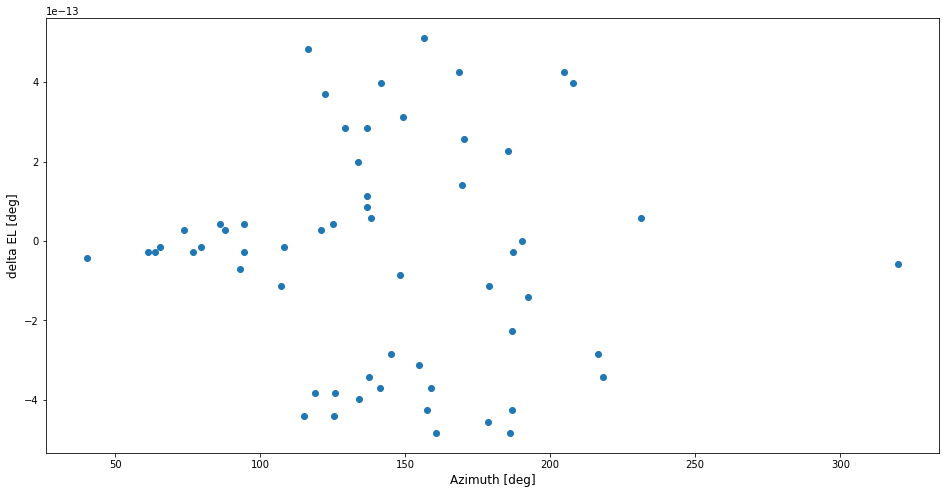

In [150]:
%matplotlib inline
fig = plt.figure(figsize=(16,8))
plt.scatter(ddf['boresightRa'], (ddf['originRa']-ddf['boresightRa']))
#plt.title('2022 April 7th Pointing', fontsize = 16)
plt.ylabel('delta EL [deg]',fontsize=12)
plt.xlabel('Azimuth [deg]',fontsize=12)
plt.show()

In [50]:
#exposures = [2022040700159, 2022040700312]
exposures = [2022040700159, 2022040700163]

In [32]:
# Measure x, y and r pointing error in origin and target images for each slew test.

line= [] 

for exposure in np.arange(2022050500291,2022050500407, 2):
    print(exposure) 
    
    data_id = {'instrument': 'LATISS', 'exposure': exposure, 'detector':0}

    exp = bestEffort.getExposure(data_id)
    
    # Get the centroid WCS position
    centroid_ra, centroid_dec, centroid_radec, centroid_az, centroid_alt = centroid_coordinates(exp)
    
    
    # Get the origin coordinates from 2036, 2000
    origin_ra, origin_dec, origin_radec, origin_az, origin_alt = origin2_coordinates(exp) 
    
    
    # Calculate distance boresight to centroid
    distance = centroid_radec.separation(origin_radec).asArcseconds()
    
    # in the detector coordinates 
    dx, dy, dr = calculate_xy_offsets(exp)
    
    # Measure offsets 
    
    delta_ra = (centroid_ra - origin_ra)*3600
    delta_dec = (centroid_dec - origin_dec)*3600
    delta_radec = np.sqrt(delta_ra**2 + delta_dec**2)
    
    delta_az = (centroid_az - origin_az)*3600
    delta_el = (centroid_alt - origin_alt)*3600
    delta_azel = np.sqrt(delta_az**2 + delta_el**2)
    
    line.append(
        {'exposures': exposure,
         'azimuth': origin_az,
         'elevation': origin_alt, 
         'delta_ra': delta_ra,  
         'delta_dec': delta_dec,
         'delta_radec': delta_radec,
         'pointing_distance_radec': distance, 
         'delta_az': delta_az,
         'delta_el': delta_el,
         'delta_azel': delta_azel,
         'delta_x [pixels]': dx,
         'delta_y [pixels]': dy, 
         'delta_xy [pixels]': dr,
        }
    )
    
df = pd.DataFrame(line)   

2022050500291


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gf36ae6ace1+dd0c26d1c5/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gf36ae6ace1+dd0c26d1c5/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


(133.5990620213, +30.2186712523)


2022050500293


(144.9958851277, +10.5112044335)


2022050500295


(141.4043988648, -13.3299894825)


2022050500297


(154.9137386857, +22.5072004983)


2022050500299


(159.0480358249, +9.6076957388)


2022050500301


(178.4684491247, +20.3359741033)


2022050500303


(160.6383315532, -2.5212460042)


2022050500305


(141.5855024490, -25.1046591149)


2022050500307


(178.8690942769, +5.8198412024)


2022050500309


(186.7541942754, +0.1186763761)


2022050500311


(156.6582640193, -20.4532802576)


2022050500313


(170.1079304030, -17.4748528389)


2022050500315


(187.1542720363, -11.0225020788)


2022050500317


(204.8259802891, -12.0929369888)


2022050500319


(186.1699807444, -28.9451518781)


2022050500321


(185.5209036304, -31.9474858479)


2022050500323


(216.5021607706, -30.2868985458)


2022050500325


(169.4941966796, -36.5971858480)


2022050500327


(192.2682970190, -43.9502198306)


2022050500329


(218.3099029709, -50.9339682280)


2022050500331


(186.8606201531, -51.6672636854)


2022050500333


(148.3112811536, -37.4288569826)


2022050500335


(231.1223613948, -59.7525235849)


2022050500337


(190.3602645620, -59.7953455282)


2022050500339


(149.2837044378, -46.6792881225)


2022050500341


(207.9837896460, -70.7567786020)


2022050500343


(157.5489588696, -62.4908176680)


2022050500345


(168.4602634535, -73.0913269728)


2022050500347


(319.9433606516, -82.2044097443)


2022050500349


(119.0652981183, -69.6462058677)


2022050500351


(116.4218913337, -67.0703683499)


2022050500353


(40.1566650924, -69.0817951085)


2022050500355


(129.3172338497, -48.9113385189)


2022050500357


(92.9062387176, -59.2430395911)


2022050500359


(94.4566377643, -51.2722798235)


2022050500361


(65.4549233530, -51.8159966062)


2022050500363


(137.6601338582, -33.1024733642)


2022050500365


(76.9548449187, -43.1867855596)


2022050500367


(61.4217935992, -40.5256671578)


2022050500369


(120.9614918415, -35.5116890664)


2022050500371


(63.9181989066, -30.5550839816)


2022050500373


(86.2898668123, -26.9905118122)


2022050500375


(73.7772788344, -11.7485542208)


2022050500377


(94.3448930616, -11.3789883959)


2022050500379


(79.6017276597, -2.5341065973)


2022050500381


(114.9931481434, -19.0584372719)


2022050500383


(125.5981075294, -21.0070671090)


2022050500385


(87.9395254169, +4.3589760682)


2022050500387


(108.1397138081, +0.5827942186)


2022050500389


(134.1867640344, -19.4752509164)


2022050500391


(107.2406064309, +14.5671797562)


2022050500393


(125.7469612398, -7.7217782979)


2022050500395


(122.2699369852, +10.5111010787)


2022050500397


(124.9627034369, +24.7562472959)


2022050500399


(136.9279242240, -5.2561295499)


2022050500401


(138.2277814293, +17.4777748776)


2022050500403


(136.7988203413, +18.1444772943)


2022050500405


(136.7987586569, +18.1444398061)


In [20]:
df.head()

,exposures,azimuth,elevation,delta_ra,delta_dec,delta_radec,pointing_distance_radec,delta_az,delta_el,delta_azel,delta_x [pixels],delta_y [pixels],delta_xy [pixels]
0,2022050500291,359.055148,29.613289,2.463334,1.508394,2.888471,2.608873,2.479948,-1.469384,2.882574,-2.645981,-0.282791,2.661050
1,2022050500293,15.157747,48.175773,4.248525,3.019193,5.212053,5.154110,5.064676,-3.893988,6.388590,-5.200326,-0.166235,5.202982
2,2022050500295,20.650756,72.186331,3.157603,4.952406,5.873397,5.828099,4.493091,-5.664186,7.229860,-5.853166,-0.559158,5.879814
3,2022050500297,22.059438,34.071946,5.151414,2.042975,5.541734,5.179020,4.519200,-3.579660,5.765166,-5.146613,-0.954501,5.234377
4,2022050500299,33.456644,44.242190,3.276523,2.201542,3.947454,3.909393,2.469061,-3.486733,4.272420,-3.739163,-1.334673,3.970226


In [23]:
df.columns

Index(['exposures', 'azimuth', 'elevation', 'delta_ra', 'delta_dec',
       'delta_radec', 'pointing_distance_radec', 'delta_az', 'delta_el',
       'delta_azel', 'delta_x [pixels]', 'delta_y [pixels]',
       'delta_xy [pixels]'],
      dtype='object')

In [1]:
fig, axs = plt.subplots(1, 3, figsize=(16*0.5+3, 9*0.5))
plt.subplots_adjust(wspace=0.4)

az, el = df.azimuth.to_numpy(), df.elevation.to_numpy()
off = df.delta_azel.to_numpy()
dAZ, dEL = df.delta_az.to_numpy(), df.delta_el.to_numpy()

im0 = axs[0].scatter(az, el, s=100, alpha=0.8, c=dAZ, vmin=0, vmax=10, label=f'{len(df)} Fields', cmap='jet')
axs[0].set_ylabel('Elevation [deg]',fontsize=16)
axs[0].set_title(r'Azimuth [deg]',fontsize=16)
axs[0].xaxis.set_ticks_position('top')

im1 = axs[1].scatter(dEL, el, s=100, c=az, cmap='jet')#, vmin=-40, vmax=40)
axs[1].set_ylabel('Elevation [deg]',fontsize=16)
axs[1].set_title(r'$\Delta$ EL [arcsec]',fontsize=16)
axs[1].xaxis.set_ticks_position('top')

im2 = axs[2].scatter(dAZ, az,s=100, c=el, cmap='jet',vmin=35, vmax=80)#, vmin=-30., vmax=0.)
axs[2].set_ylabel('Azimuth [deg]',fontsize=16)
axs[2].set_title(r'$\Delta$ Az [arcsec]',fontsize=16)
axs[2].xaxis.set_ticks_position('top')

plt.colorbar(im0, ax=axs[0], pad=0.025, orientation='horizontal').set_label(r'PNT_Offset [arcsec]',fontsize=12)
plt.colorbar(im1, ax=axs[1], pad=0.025, orientation='horizontal').set_label(r'Az [deg]',fontsize=12)
plt.colorbar(im2, ax=axs[2], pad=0.025, orientation='horizontal').set_label(r'El [deg]',fontsize=12)
plt.tight_layout()
# fig.savefig(f'figures/AzEl_pannel_{month}.png',facecolor='w',transparent=False,dpi=100)

NameError: name 'plt' is not defined

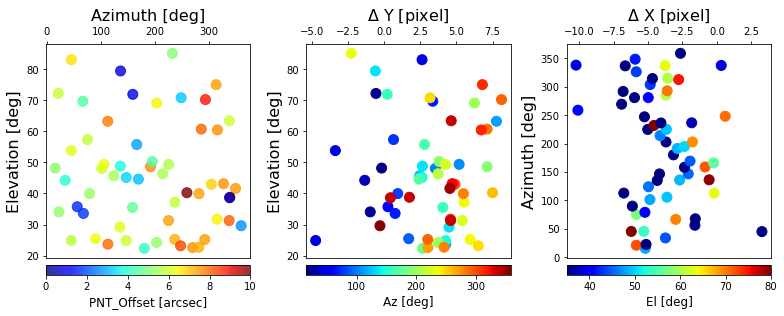

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(16*0.5+3, 9*0.5))
plt.subplots_adjust(wspace=0.4)

az, el = df.azimuth.to_numpy(), df.elevation.to_numpy()
off = df['delta_xy [pixels]'].to_numpy()
dAZ, dEL = df['delta_x [pixels]'].to_numpy(), df['delta_y [pixels]'].to_numpy()

im0 = axs[0].scatter(az, el, s=100, alpha=0.8, c=off, vmin=0, vmax=10, label=f'{len(df)} Fields', cmap='jet')
axs[0].set_ylabel('Elevation [deg]',fontsize=16)
axs[0].set_title(r'Azimuth [deg]',fontsize=16)
axs[0].xaxis.set_ticks_position('top')

im1 = axs[1].scatter(dEL, el, s=100, c=az, cmap='jet')#, vmin=-40, vmax=40)
axs[1].set_ylabel('Elevation [deg]',fontsize=16)
axs[1].set_title(r'$\Delta$ Y [pixel]',fontsize=16)
axs[1].xaxis.set_ticks_position('top')

im2 = axs[2].scatter(dAZ, az,s=100, c=el, cmap='jet',vmin=35, vmax=80)#, vmin=-30., vmax=0.)
axs[2].set_ylabel('Azimuth [deg]',fontsize=16)
axs[2].set_title(r'$\Delta$ X [pixel]',fontsize=16)
axs[2].xaxis.set_ticks_position('top')

plt.colorbar(im0, ax=axs[0], pad=0.025, orientation='horizontal').set_label(r'PNT_Offset [arcsec]',fontsize=12)
plt.colorbar(im1, ax=axs[1], pad=0.025, orientation='horizontal').set_label(r'Az [deg]',fontsize=12)
plt.colorbar(im2, ax=axs[2], pad=0.025, orientation='horizontal').set_label(r'El [deg]',fontsize=12)
plt.tight_layout()
# fig.savefig(f'figures/AzEl_pannel_{month}.png',facecolor='w',transparent=False,dpi=100)

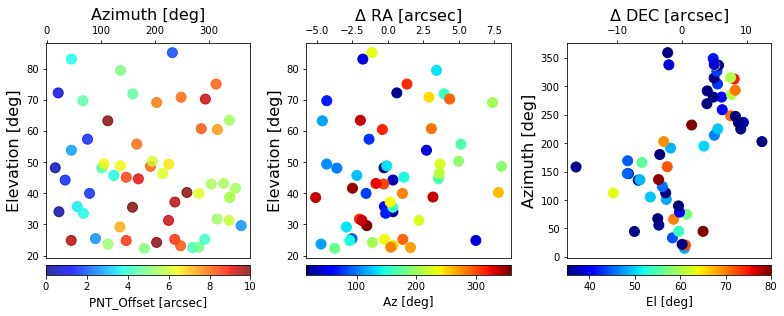

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(16*0.5+3, 9*0.5))
plt.subplots_adjust(wspace=0.4)

az, el = df.azimuth.to_numpy(), df.elevation.to_numpy()
off = df.delta_radec.to_numpy()
dAZ, dEL = df.delta_ra.to_numpy(), df.delta_dec.to_numpy()

im0 = axs[0].scatter(az, el, s=100, alpha=0.8, c=off, vmin=0, vmax=10, label=f'{len(df)} Fields', cmap='jet')
axs[0].set_ylabel('Elevation [deg]',fontsize=16)
axs[0].set_title(r'Azimuth [deg]',fontsize=16)
axs[0].xaxis.set_ticks_position('top')

im1 = axs[1].scatter(dEL, el, s=100, c=az, cmap='jet')#, vmin=-40, vmax=40)
axs[1].set_ylabel('Elevation [deg]',fontsize=16)
axs[1].set_title(r'$\Delta$ RA [arcsec]',fontsize=16)
axs[1].xaxis.set_ticks_position('top')

im2 = axs[2].scatter(dAZ, az,s=100, c=el, cmap='jet',vmin=35, vmax=80)#, vmin=-30., vmax=0.)
axs[2].set_ylabel('Azimuth [deg]',fontsize=16)
axs[2].set_title(r'$\Delta$ DEC [arcsec]',fontsize=16)
axs[2].xaxis.set_ticks_position('top')

plt.colorbar(im0, ax=axs[0], pad=0.025, orientation='horizontal').set_label(r'PNT_Offset [arcsec]',fontsize=12)
plt.colorbar(im1, ax=axs[1], pad=0.025, orientation='horizontal').set_label(r'Az [deg]',fontsize=12)
plt.colorbar(im2, ax=axs[2], pad=0.025, orientation='horizontal').set_label(r'El [deg]',fontsize=12)
plt.tight_layout()
# fig.savefig(f'figures/AzEl_pannel_{month}.png',facecolor='w',transparent=False,dpi=100)

In [39]:
df

,exposures,azimuth,elevation,delta_ra,delta_dec,delta_radec,pointing_distance_radec,delta_az,delta_el,delta_azel,delta_x [pixels],delta_y [pixels],delta_xy [pixels]
0,2022050500291,359.056448,29.612477,-2.182202,-1.487810,2.641133,2.401941,-2.200068,1.453264,2.636717,-2.645981,-0.282791,2.661050
1,2022050500293,15.158964,48.174643,0.410797,-0.275286,0.494507,0.488795,0.684034,0.175752,0.706251,-5.200326,-0.166235,5.202982
2,2022050500295,20.651709,72.184971,0.562895,0.626087,0.841923,0.831861,1.062722,-0.765765,1.309876,-5.853166,-0.559158,5.879814
3,2022050500297,22.060721,34.071047,0.047650,0.351771,0.354983,0.354514,-0.098856,-0.344962,0.358847,-5.146613,-0.954501,5.234377
4,2022050500299,33.457881,44.241117,-1.445941,0.354606,1.488789,1.469099,-1.982233,0.376807,2.017729,-3.739163,-1.334673,3.970226
5,2022050500301,44.676145,24.868847,-7.321805,6.205670,9.597873,9.254411,-10.196078,-0.287885,10.200141,3.269333,-4.728122,5.748363
6,2022050500303,45.076480,53.790429,-0.462833,2.720501,2.759591,2.759516,-3.436656,-1.869375,3.912183,-5.308771,-3.366595,6.286255
7,2022050500305,44.959548,83.034205,3.286379,-1.772305,3.733812,3.463695,27.981575,-0.694749,27.990199,-6.219566,2.628537,6.752200
8,2022050500307,55.877435,35.730455,-3.550586,-0.246383,3.559125,3.540868,-2.807868,2.710009,3.902341,-1.597583,0.271317,1.620458
9,2022050500309,67.241002,33.572339,-3.717024,-0.156551,3.720319,3.720311,-2.546346,3.056352,3.978086,-1.572013,0.765441,1.748463


In [17]:
boresight_radec.separation(centroid_radec).as
distance

<bound method PyCapsule.asArcminutes of Angle(0.00016933932697857945, degrees)>

In [42]:
info = exp.getInfo()
vi = info.getVisitInfo()
    
skyLocation = SkyCoord(centroid_ra, centroid_dec, unit=u.deg)
altAz = AltAz(obstime=vi.date.toPython(), location=AUXTEL_LOCATION)
obsAltAz = skyLocation.transform_to(altAz)
centroid_alt = geom.Angle(obsAltAz.alt.degree, geom.degrees).asDegrees()
centroid_az = geom.Angle(obsAltAz.az.degree, geom.degrees).asDegrees()
print(centroid_alt)

38.62573476456108


In [43]:
boresight_azel = vi.getBoresightAzAlt()
boresight_az = boresight_azel[0].asDegrees()
boresight_alt = boresight_azel[1].asDegrees()
print((boresight_alt))

38.7882023139973


In [63]:
(15*30)/3600

0.125

In [36]:
df.to_csv('PointingMay-wcs.txt', index='exposures')

In [56]:
df = pd.read_csv('PointingMay_radec_azel_xy.txt') 

In [37]:
df.iloc[df.delta_az.abs().argsort()]

,exposures,azimuth,elevation,delta_ra,delta_dec,delta_radec,pointing_distance_radec,delta_az,delta_el,delta_azel,delta_x [pixels],delta_y [pixels],delta_xy [pixels]
27,2022050500345,168.988813,44.612376,-8.365193,3.567831,9.094277,4.318472,-0.067274,4.318191,4.318715,-1.950630,2.411715,3.101826
3,2022050500297,22.060721,34.071047,0.047650,0.351771,0.354983,0.354514,-0.098856,-0.344962,0.358847,-5.146613,-0.954501,5.234377
26,2022050500343,165.907079,55.753308,-6.155589,5.149607,8.025568,5.882405,0.291279,5.880213,5.887423,-0.242495,2.804222,2.814688
23,2022050500337,146.523217,45.134147,-8.419289,1.129827,8.494759,4.383778,0.344208,4.377063,4.390576,-2.083189,2.628976,3.354279
28,2022050500347,180.001043,22.350285,-3.405263,-3.755830,5.069722,3.784121,-0.458718,3.760109,3.787986,-3.153578,2.667486,4.130440
31,2022050500353,202.690739,24.220611,12.376116,-1.099117,12.424826,4.553321,0.648403,4.514625,4.560950,-3.697989,3.733814,5.255139
1,2022050500293,15.158964,48.174643,0.410797,-0.275286,0.494507,0.488795,0.684034,0.175752,0.706251,-5.200326,-0.166235,5.202982
25,2022050500341,158.042124,35.514080,-16.339279,0.348964,16.343005,5.396391,0.718289,5.364533,5.412408,-2.355621,4.068345,4.701105
2,2022050500295,20.651709,72.184971,0.562895,0.626087,0.841923,0.831861,1.062722,-0.765765,1.309876,-5.853166,-0.559158,5.879814
22,2022050500335,146.395244,24.843422,-8.253755,-2.690820,8.681301,4.952444,1.428199,4.779710,4.988524,-4.168690,4.255827,5.957352


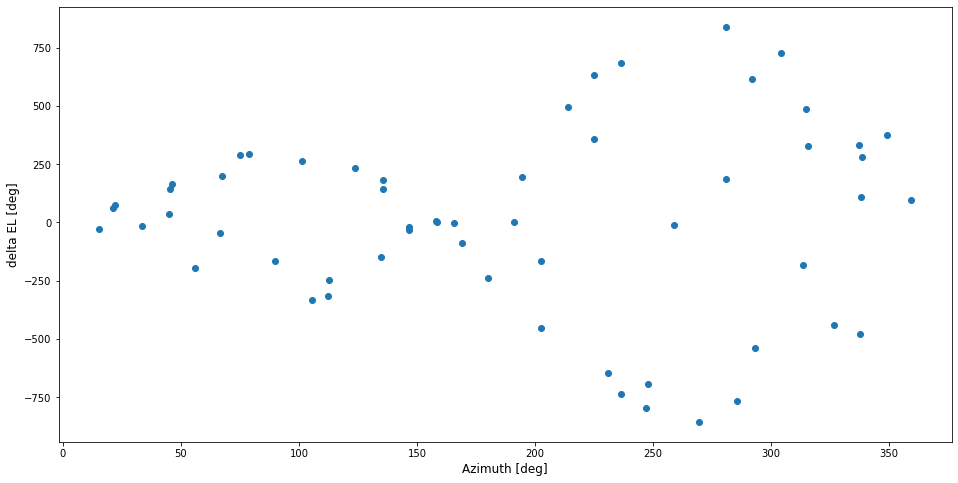

In [81]:
%matplotlib inline
fig = plt.figure(figsize=(16,8))
plt.scatter(df['azimuth'], df['delta_el']*np.cos(df['azimuth'].to_numpy()*180/np.pi))
#plt.title('2022 April 7th Pointing', fontsize = 16)
plt.ylabel('delta EL [deg]',fontsize=12)
plt.xlabel('Azimuth [deg]',fontsize=12)
plt.show()

In [36]:
np.sqrt(((df['pointing_origin']**2).sum())/len(df))

11.43627863561008

In [38]:
# Calculate the relative pointing difference between origin and target position or pointing accuracy after each slew. 
len(df)

(df[df['pointing_origin']>10]) 

KeyError: 'pointing_origin'

***

In [21]:
# Calculate pointing accuracy RMS. 
rms = np.sqrt(((df['Relative_pointing[arcsec]']**2).sum())/len(df))
print(f'The pointing accuracy RMS for the analyzed large slew and settle tests is {rms:0.2f} arcsec')

The pointing accuracy RMS for the analyzed large slew and settle tests is 30.34 arcsec


# WCS sky origin - boresight. 

In [48]:
def calculate_xy_offsets(exp):
    pixel_scale = 0.09569  # arcsec/pixel
    #boresight_position = PointD(2036.5, 2000.5)
    boresight_position = PointD(2088.5, 2006.5)

    """Returns x/y offset in arcseconds from an exp based on current centroid
    and desired position (which is the boresight position in pixels)"""

    #Measure Centroids
    result = qm.run(exp)
    centroids = PointD(result.brightestObjCentroid[0], result.brightestObjCentroid[1])


    dx_arcsec, dy_arcsec = pixel_scale * (
        centroids - boresight_position
    )

    dr_arcsec = np.sqrt(dx_arcsec**2 + dy_arcsec**2)

    return dx_arcsec, dy_arcsec, dr_arcsec

In [49]:
def get_azel(exp):
    info = exp.getInfo()
    vi = info.getVisitInfo()
    
    azAlt = vi.getBoresightAzAlt()
    az = azAlt[0].asDegrees()
    el = azAlt[1].asDegrees()
    
    return az, el

In [50]:
#exposures = [2022040700159, 2022040700312]
exposures = [2022040700159, 2022040700163]

In [50]:
# Measure x, y and r pointing error in origin and target images for each slew test.
# pointing_origin, exposures = [], []
# dx_origin, dx_target = [], []
# az, el = [], []

line= [] 

for exposure in np.arange(2022040700159,2022040700311, 2):
    print(exposure) 
    
    data_id = {'instrument': 'LATISS', 'exposure': exposure, 'detector':0}

    exp = bestEffort.getExposure(data_id)
    
    dx, dy, dr = calculate_xy_offsets(exp)
    
    az, el = get_azel(exp)
    
    line.append(
        {'exposures': exposure,
         'azimuth': az,
         'elevation': el, 
         'dx_origin':dx,  
         'dy_origin': dy,
         'pointing_origin' : dr
        }
    )
    
df = pd.DataFrame(line)   

2022040700159


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gf36ae6ace1+1d7ae49801/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gf36ae6ace1+1d7ae49801/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


2022040700161


2022040700163


2022040700165


2022040700167


2022040700169


2022040700171


2022040700173


2022040700175


2022040700177


2022040700179


2022040700181


2022040700183


2022040700185


2022040700187


2022040700189


2022040700191


2022040700193


2022040700195


2022040700197


2022040700199


2022040700201


2022040700203


2022040700205


2022040700207


2022040700209


2022040700211


2022040700213


2022040700215


2022040700217


2022040700219


2022040700221


2022040700223


2022040700225


2022040700227


2022040700229


2022040700231


2022040700233


2022040700235


2022040700237


2022040700239


2022040700241


2022040700243


2022040700245


2022040700247


2022040700249


2022040700251


2022040700253


2022040700255


2022040700257


2022040700259


2022040700261


2022040700263


2022040700265


2022040700267


2022040700269


2022040700271


2022040700273


2022040700275


2022040700277


2022040700279


2022040700281


2022040700283


2022040700285


2022040700287


2022040700289


2022040700291


2022040700293


2022040700295


2022040700297


2022040700299


2022040700301


2022040700303


2022040700305


2022040700307


2022040700309


In [40]:
df

,exposures,azimuth,elevation,delta_ra,delta_dec,delta_radec,pointing_distance_radec,delta_az,delta_el,delta_azel,delta_x [pixels],delta_y [pixels],delta_xy [pixels]
0,2022050500291,359.056448,29.612477,-2.182202,-1.487810,2.641133,2.401941,-2.200068,1.453264,2.636717,-2.645981,-0.282791,2.661050
1,2022050500293,15.158964,48.174643,0.410797,-0.275286,0.494507,0.488795,0.684034,0.175752,0.706251,-5.200326,-0.166235,5.202982
2,2022050500295,20.651709,72.184971,0.562895,0.626087,0.841923,0.831861,1.062722,-0.765765,1.309876,-5.853166,-0.559158,5.879814
3,2022050500297,22.060721,34.071047,0.047650,0.351771,0.354983,0.354514,-0.098856,-0.344962,0.358847,-5.146613,-0.954501,5.234377
4,2022050500299,33.457881,44.241117,-1.445941,0.354606,1.488789,1.469099,-1.982233,0.376807,2.017729,-3.739163,-1.334673,3.970226
5,2022050500301,44.676145,24.868847,-7.321805,6.205670,9.597873,9.254411,-10.196078,-0.287885,10.200141,3.269333,-4.728122,5.748363
6,2022050500303,45.076480,53.790429,-0.462833,2.720501,2.759591,2.759516,-3.436656,-1.869375,3.912183,-5.308771,-3.366595,6.286255
7,2022050500305,44.959548,83.034205,3.286379,-1.772305,3.733812,3.463695,27.981575,-0.694749,27.990199,-6.219566,2.628537,6.752200
8,2022050500307,55.877435,35.730455,-3.550586,-0.246383,3.559125,3.540868,-2.807868,2.710009,3.902341,-1.597583,0.271317,1.620458
9,2022050500309,67.241002,33.572339,-3.717024,-0.156551,3.720319,3.720311,-2.546346,3.056352,3.978086,-1.572013,0.765441,1.748463


In [12]:
df.to_csv('PointingApril.txt')

In [5]:
df = pd.read_csv(´PointingApril.txt´) 

SyntaxError: invalid character in identifier (1416278915.py, line 1)

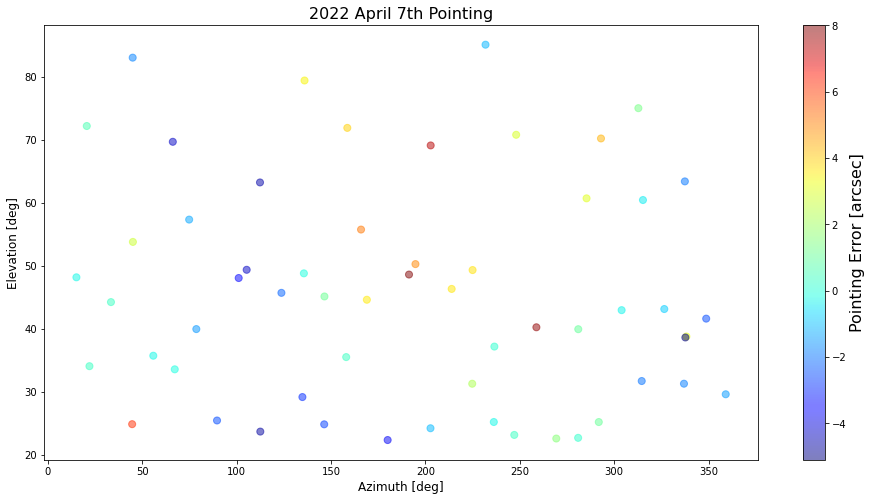

In [53]:
%matplotlib inline
fig = plt.figure(figsize=(16,8))
plt.scatter(df['azimuth'], df['elevation'], 
            s=50, alpha=0.5, c=df['delta_dec'], label=f'Pointing Error', cmap='jet')
plt.title('2022 April 7th Pointing', fontsize = 16)
plt.colorbar().set_label('Pointing Error [arcsec]',fontsize=16)
plt.ylabel('Elevation [deg]',fontsize=12)
plt.xlabel('Azimuth [deg]',fontsize=12)
plt.show()

In [53]:
np.sqrt(((df['pointing_origin']**2).sum())/len(df))

15.28117219217928

In [54]:
# Calculate the relative pointing difference between origin and target position or pointing accuracy after each slew. 
len(df)

(df[df['pointing_origin']>10]) 

,exposures,azimuth,elevation,dx_origin,dy_origin,pointing_origin
2,2022040700163,22.657208,63.482507,-11.938966,1.746821,12.066080
5,2022040700169,42.837597,79.642034,-28.857139,1.960139,28.923634
6,2022040700171,45.388340,57.268978,-12.080630,3.833643,12.674322
7,2022040700173,68.216398,67.838822,-18.640733,2.598924,18.821034
8,2022040700175,67.709831,36.129588,-10.548647,0.218469,10.550909
9,2022040700177,75.333283,47.294385,-10.728641,2.706948,11.064868
10,2022040700179,90.000282,24.990776,-16.156700,-19.051145,24.979694
14,2022040700187,112.002506,70.632324,-18.438678,-2.943649,18.672170
18,2022040700195,136.106829,72.081512,-19.384137,-6.168262,20.341884
19,2022040700197,146.653490,22.075075,-16.521149,-25.344972,30.254189


***

In [21]:
# Calculate pointing accuracy RMS. 
rms = np.sqrt(((df['Relative_pointing[arcsec]']**2).sum())/len(df))
print(f'The pointing accuracy RMS for the analyzed large slew and settle tests is {rms:0.2f} arcsec')

The pointing accuracy RMS for the analyzed large slew and settle tests is 30.34 arcsec


# Pointing difference from images using wcs and Merlin's code

In [12]:
def getExpPositionOffset(exp1, exp2):
    # need the exps if we want altAz because we need the observation times
    wcs1 = exp1.getWcs()
    wcs2 = exp2.getWcs()
    p1 = wcs1.getSkyOrigin()
    p2 = wcs2.getSkyOrigin()

    vi1 = exp1.getInfo().getVisitInfo()
    vi2 = exp2.getInfo().getVisitInfo()

    # AltAz via astropy
    skyLocation1 = SkyCoord(p1.getRa().asRadians(), p1.getDec().asRadians(), unit=u.rad)
    altAz1 = AltAz(obstime=vi1.date.toPython(), location=AUXTEL_LOCATION)
    obsAltAz1 = skyLocation1.transform_to(altAz1)
    alt1 = geom.Angle(obsAltAz1.alt.degree, geom.degrees)
    az1 = geom.Angle(obsAltAz1.az.degree, geom.degrees)

    skyLocation2 = SkyCoord(p2.getRa().asRadians(), p2.getDec().asRadians(), unit=u.rad)
    altAz2 = AltAz(obstime=vi2.date.toPython(), location=AUXTEL_LOCATION)
    obsAltAz2 = skyLocation2.transform_to(altAz2)
    alt2 = geom.Angle(obsAltAz2.alt.degree, geom.degrees)
    az2 = geom.Angle(obsAltAz2.az.degree, geom.degrees)

    # ra/dec via the stack
    # NB using the wcs not the exp visitInfo as that's unfitted
    # and so is always identical for a given object/pointing
    ra1 = p1[0]
    ra2 = p2[0]
    dec1 = p1[1]
    dec2 = p2[1]

    angular_offset = p1.separation(p2).asArcseconds()
    delta_pixels = angular_offset / wcs1.getPixelScale().asArcseconds()

    ret = pipeBase.Struct(deltaRa=ra1-ra2,
                          deltaDec=dec1-dec2,
                          deltaAlt=alt1-alt2,
                          deltaAz=az1-az2,
                          delta_pixel_magnitude=delta_pixels,
                          angular_offset_arcsec=angular_offset
                          )

    return ret

In [22]:
for i in np.arange(2021110400857, 2021110400860):
    expo1 = i
    expo2 = i+1

    data_id = {'instrument': 'LATISS', 'exposure': expo1, 'detector':0}

    exp1 = bestEffort.getExposure(data_id)

    data_id = {'instrument': 'LATISS', 'exposure': expo2, 'detector':0}

    exp2 = bestEffort.getExposure(data_id)


    print(getExpPositionOffset(exp1, exp2))

Struct(deltaRa=4.87839e-07 rad; deltaDec=-7.26963e-08 rad; deltaAlt=-0.000832188 rad; deltaAz=0.000206465 rad; delta_pixel_magnitude=0.7141095566194752; angular_offset_arcsec=0.06833671397775147)


Struct(deltaRa=-1.81154e-06 rad; deltaDec=-2.43979e-08 rad; deltaAlt=-0.00083027 rad; deltaAz=0.000205164 rad; delta_pixel_magnitude=2.5876836078883008; angular_offset_arcsec=0.2476283826922847)


Struct(deltaRa=1.50157e-07 rad; deltaDec=7.46367e-08 rad; deltaAlt=-0.000832304 rad; deltaAz=0.000204781 rad; delta_pixel_magnitude=0.2680822017770324; angular_offset_arcsec=0.025654126274476555)


In [120]:
# Measure x, y and r pointing error in origin and target images for each slew test.

line= [] 

for exposure in np.arange(2022050500291,2022050500407, 2):
    print(exposure) 
    
    data_id = {'instrument': 'LATISS', 'exposure': exposure, 'detector':0}

    exp = bestEffort.getExposure(data_id)
    
    # Get the sky origin 
    origin_ra, origin_dec, origin_radec, origin_az, origin_alt = origin(exp)
    
    # Get the boresight coordinates 
    boresight_ra, boresight_dec, boresight_radec, boresight_az, boresight_alt = boresight_coordinates(exp)
    
    distance = boresight_radec.separation(origin_radec).asArcseconds()

    # RADEC from metadata: 
    exp.getEx
    line.append(
        {'exposures': exposure,
         'boresightAz': boresight_az,
         'boresightEl':boresight_alt, 
         'wcsAz': origin_az, 
         'wcsEL': origin_alt,
         'boresightRa': boresight_ra,
         'boresightDec':boresight_dec, 
         'wcsRa': origin_ra, 
         'wcsDec': origin_dec,
         'distance':distance
        }
    )
    
ddf = pd.DataFrame(line)   

2022050500291


(133.5977715947, +30.2178389734)
2022050500293


(144.9948190921, +10.5102893005)
2022050500295


(141.4036781124, -13.3311912380)
2022050500297


(154.9123209734, +22.5067307192)
2022050500299


(159.0467240292, +9.6071827010)
2022050500301


(178.4669842364, +20.3361962640)
2022050500303


(160.6370416258, -2.5217707813)
2022050500305


(141.5844274953, -25.1056533830)
2022050500307


(178.8676991136, +5.8199392684)
2022050500309


(186.7528379808, +0.1189871112)
2022050500311


(156.6568528095, -20.4537135708)
2022050500313


(170.1064731668, -17.4749163294)
2022050500315


(187.1528930385, -11.0221796484)
2022050500317


(204.8247513132, -12.0922355706)
2022050500319


(186.1685004476, -28.9446438843)
2022050500321


(185.5194012679, -31.9469282224)
2022050500323


(216.5008823561, -30.2860515376)
2022050500325


(169.4926259351, -36.5965978165)
2022050500327


(192.2667547180, -43.9493812921)
2022050500329


(218.3082396266, -50.9330532411)
2022050500331


(186.8590888326, -51.6662468245)
2022050500333


(148.3100210771, -37.4278901348)
2022050500335


(231.1202630418, -59.7516187254)
2022050500337


(190.3587269377, -59.7941889548)
2022050500339


(149.2831296889, -46.6779537359)
2022050500341


(207.9815207687, -70.7556051948)
2022050500343


(157.5489661184, -62.4894262399)
2022050500345


(168.4605767818, -73.0899385284)
2022050500347


(319.9344043919, -82.2050882876)
2022050500349


(119.0688821693, -69.6455877656)
2022050500351


(116.4251844467, -67.0698298675)
2022050500353


(40.1573110430, -69.0831672958)
2022050500355


(129.3187085050, -48.9103401448)
2022050500357


(92.9088388139, -59.2434495282)
2022050500359


(94.4587106584, -51.2727841018)
2022050500361


(65.4559728008, -51.8172275446)
2022050500363


(137.6614093763, -33.1015820788)
2022050500365


(76.9559469486, -43.1879215403)
2022050500367


(61.4221997039, -40.5270239180)
2022050500369


(120.9631999627, -35.5117425168)
2022050500371


(63.9184115472, -30.5564633123)
2022050500373


(86.2906253925, -26.9917280237)
2022050500375


(73.7773263109, -11.7499448763)
2022050500377


(94.3452981656, -11.3803219487)
2022050500379


(79.6016684277, -2.5354967706)
2022050500381


(114.9940795125, -19.0595148294)
2022050500383


(125.5991653240, -21.0080473916)
2022050500385


(87.9394151386, +4.3575889877)
2022050500387


(108.1398437726, +0.5814088687)
2022050500389


(134.1875761380, -19.4764127613)
2022050500391


(107.2403012021, +14.5658200460)
2022050500393


(125.7473183545, -7.7231239781)
2022050500395


(122.2696570210, +10.5097371464)
2022050500397


(124.9619280754, +24.7550471641)
2022050500399


(136.9279001531, -5.2575207755)
2022050500401


(138.2270118265, +17.4765928384)
2022050500403


(136.7981982499, +18.1432176857)
2022050500405


(136.7981365584, +18.1431802007)


In [ ]:
# Using Johnny's code

In [ ]:
import numpy as np
import pandas as pd
from datetime import date
# from lsst.rapid.analysis.utils import getExpPositionOffset
import lsst.pipe.base as pipeBase
import lsst.geom as geom
from astropy.coordinates import SkyCoord, AltAz
import astropy.units as u
from lsst.obs.lsst.translators.latiss import AUXTEL_LOCATION


In [ ]:
def getExpPositionOffset(exp1, exp2):
    # need the exps if we want altAz because we need the observation times
    wcs1 = exp1.getWcs()
    wcs2 = exp2.getWcs()
    p1 = wcs1.getSkyOrigin()
    p2 = wcs2.getSkyOrigin()

    vi1 = exp1.getInfo().getVisitInfo()
    vi2 = exp2.getInfo().getVisitInfo()

    # AltAz via astropy
    skyLocation1 = SkyCoord(p1.getRa().asRadians(), p1.getDec().asRadians(), unit=u.rad)
    altAz1 = AltAz(obstime=vi1.date.toPython(), location=AUXTEL_LOCATION)
    obsAltAz1 = skyLocation1.transform_to(altAz1)
    alt1 = geom.Angle(obsAltAz1.alt.degree, geom.degrees)
    az1 = geom.Angle(obsAltAz1.az.degree, geom.degrees)

    skyLocation2 = SkyCoord(p2.getRa().asRadians(), p2.getDec().asRadians(), unit=u.rad)
    altAz2 = AltAz(obstime=vi2.date.toPython(), location=AUXTEL_LOCATION)
    obsAltAz2 = skyLocation2.transform_to(altAz2)
    alt2 = geom.Angle(obsAltAz2.alt.degree, geom.degrees)
    az2 = geom.Angle(obsAltAz2.az.degree, geom.degrees)

    # ra/dec via the stack
    # NB using the wcs not the exp visitInfo as that's unfitted
    # and so is always identical for a given object/pointing
    ra1 = p1[0]
    ra2 = p2[0]
    dec1 = p1[1]
    dec2 = p2[1]

    angular_offset = p1.separation(p2).asArcseconds()
    delta_pixels = angular_offset / wcs1.getPixelScale().asArcseconds()

    ret = pipeBase.Struct(deltaRa=ra1-ra2,
                          deltaDec=dec1-dec2,
                          deltaAlt=alt1-alt2,
                          deltaAz=az1-az2,
                          delta_pixel_magnitude=delta_pixels,
                          angular_offset_arcsec=angular_offset
                          )

    return ret

In [ ]:
def getSkyOriginValues(wcsInfo):
    ra = wcsInfo.getSkyOrigin().getRa().asDegrees()
    dec = wcsInfo.getSkyOrigin().getDec().asDegrees()
    return ra, dec

In [ ]:
def get_exposure_info(exposure):
    info = exposure.getInfo()
    vi = info.getVisitInfo()

    expTime = vi.getExposureTime()
    date = vi.getDate().toPython()
    mjd = vi.getDate().get()

    airmass = vi.getBoresightAirmass()
    rotangle = vi.getBoresightRotAngle().asDegrees()
    
    raDec = vi.boresightRaDec
    ra = raDec[0].asDegrees()
    dec = raDec[1].asDegrees()
    
    azAlt = vi.getBoresightAzAlt()
    az = azAlt[0].asDegrees()
    el = azAlt[1].asDegrees()
    
    info = {'DATE': date, 'MJD': mjd, 'EXPTIME': expTime, 'RA': ra, 'DEC': dec,
            'AIRMASS': airmass, 'ROT_ANGLE': rotangle, 'AZ':az, 'EL':el}
    return info


In [ ]:
def query_main_pointing_info(expId):
    day_obs = int(str(expId)[:8])
    dataId = {"instrument": instrument, "exposure.day_obs": day_obs, "visit": expId, "detector": 0}
    
    raw = butler.get('raw', dataId)
    fitted = butler.get('calexp', dataId)
    offset = getExpPositionOffset(raw, fitted)
    
    # get offset
    dRa = offset.deltaRa.asArcminutes()
    dDec = offset.deltaDec.asArcminutes()
    dAz = offset.deltaAz.asArcminutes()
    dEl = offset.deltaAlt.asArcminutes()
    angular_offset = offset.angular_offset_arcsec/60. # arcminutes
    
    # get pointing
    wcsFitted = fitted.getWcs()
    ra, dec = getSkyOriginValues(wcsFitted)
    
    # get metadata
    mData = raw.getMetadata().toDict()#butler.get('raw.metadata', dataId).toDict()
        
    # querying some basic info about the exposure
    info = get_exposure_info(raw)
    
    for col in mylist:
        info[col+'_MD'] = mData[col] 

    info['RA_WCS'] = ra
    info['DEC_WCS'] = dec
    info['dRA'] = dRa
    info['dDEC'] = dDec
    info['dAZ'] = dAz
    info['dEL'] = dEl
    info['PNT_OFFSET'] = angular_offset
    return info

In [ ]:
nCores = 10
# metada columns it would be stored
mylist = ['RA','DEC','EXPTIME','TEMP_SET','CCDTEMP','FILTER',
          'ELSTART','ELEND','AZSTART','AZEND','ELSTART']

# initializating the butler repo
repo = '/repo/main/butler.yaml'
repo_2 = '/project/edennihy/auxtelImagingSurveys/data/'
instrument = 'LATISS'
# collection = 'u/mfl/testProcessCcd'
# collection = 'u/mfl/testProcessCcd_srcMatchFull_181e6356'
# collection = 'u/edennihy/tickets/CAP-868_20220321a'
# collection = 'u/edennihy/tickets/CAP-851'
# collection = 'u/edennihy/tickets/SITCOM-266_20220419'
collection = 'u/edennihy/CAP-886_partial'

print('\n')
print('Querying WCS Poiting')
print(f'repo: {repo}')
print(f'collection: {collection} \n')

# import lsst.rapid.analysis.butlerUtils as bu
# butler = bu.makeDefaultLatissButler('NCSA', extraCollections=[collection])
# registry=butler.registry

import lsst.daf.butler as dafButler #Gen3 butler
butler = dafButler.Butler(repo_2, collections=[collection])
registry=butler.registry

# querying all exposure ids in this collection
dataset_refs = list(registry.queryDatasets('calexp', collections=collection))
dataset_refs = sorted(dataset_refs, key=lambda x : x.dataId['visit'])
expIds = [int(ref.dataId['visit']) for ref in dataset_refs]

# for test purposes only
# expIds = expIds[:10]

print('\nStarting Query')
print(f'Number of exposures: {len(expIds)}')

# querying the wcs poiting and the metadata info
# tables = []
# for expId in expIds:
#     print(f'exposure: {expId}')
#     tables.append(query_main_pointing_info(expId))
#     print('\n')

from joblib import Parallel, delayed
tables = Parallel(n_jobs=nCores)(delayed(query_main_pointing_info)(expId) for expId in expIds)
                   
# saving output as pandas dataframe
df = pd.DataFrame(tables, index=np.array(expIds))

date = date.today().strftime("%d%m%Y")
print(f'Date: {date}')
df.to_csv(f'data/2022_May_partial03.csv')
print(f'Saved file: data/2022_May_partial03.csv')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm

from astropy.table import Table, join

In [ ]:
%matplotlib inline


In [ ]:
from datetime import date
date = date.today().strftime("%d%m%Y")
print(f'Today is: {date}')

The Dataset

Basically, we query the WCS solution from the bulter calibrate task, the boresight pointing position and some information from the exposure metadata. The sample was queried using the script query_pointing_bluter_reviewed.py.

The main quantities of this dataset are:

RA, DEC : pointing sky position from the boersight
RA_WCS, DEC_WCS : pointing sky position from the wcs solutions
PNT_OFFSET: angular distance between the two pointings.
The other columns are exclusively from the metadata and the end with _MD: RA, DEC,MJD,EXPTIME,TEMP_SET,CCDTEMP,FILTER,ELSTART,ELEND,AZSTART,AZEND

The file data/rev_checking_auxtel_pointing_{date}.csv contains info about 1421 exposures taken from Feb 2020 up to Nov 2021. The collection used to generate this file was u/mfl/testProcessCcd_srcMatchFull_181e6356. And it's from the lsst.rapid.analysis.butlerUtils.


Caveat: Not all the images from the observation nights. The calibration filters exposures selecting preferentially crowded fields.

In [ ]:
month = 'May2022'
title = 'Feb 2022 - May 2022'


In [ ]:
import pandas as pd

df0 = pd.read_csv('data/rev_checking_auxtel_pointing_24032022.csv',index_col=0)
df1 = pd.read_csv('data/rev_checking_auxtel_pointing_Feb2022.csv',index_col=0)
df2 = pd.read_csv('data/rev_checking_auxtel_pointing_Mar2022.csv',index_col=0)
df3 = pd.read_csv('data/2022_Apr.csv',index_col=0)
df4 = pd.read_csv('data/2022_May_partial03.csv',index_col=0)

df = pd.concat([df1,df2,df3,df4])
df.DATE = pd.to_datetime(df.DATE)#.dt.date

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df2 = df[cols].copy()

In [ ]:
df['month_year'] = df['DATE'].apply(lambda x: x.strftime('%Y %b')) # e.g. Jul 2021
df['month'] = df['DATE'].dt.month
df['year'] = df['DATE'].dt.year + df.month/12

df1 = df[~outliers]

In [ ]:
sns.set_context('talk', font_scale=0.9)


In [ ]:
# fig.autofmt_xdate(rotation=45)
fig = plt.figure(figsize=(10,5))
sns.stripplot(x=df.month_year, y=df.PNT_OFFSET*60,color="black", data=df, dodge=True, alpha=.25, zorder=1)
# ax = sns.pointplot(x=df.month_year, y='PNT_OFFSET', data=df, markers="d", palette="magma", scale=.75, ci=99)

# sns.stripplot(x=df.month_year, y='PNT_OFFSET', color="black", data=df, dodge=True, alpha=.25, zorder=1)
ax = sns.pointplot(x=df.month_year, y=df.PNT_OFFSET*60, data=df, markers="d", color="#016CE4", scale=.75, ci=99, join=False)

ax.axhline(10,color='k',ls='--',lw=3, label='Pointing Req.\n 10 arcsec')
# ax.set_title('Joliette')
ax.set_ylabel('Pointing Offset [arcsec]')
ax.set_xlabel('')
ax.set_title('AuxTel Observation Runs')
ax.legend(fontsize=12)
ax.tick_params(axis='x', rotation=60)
fig.tight_layout()
# fig.savefig(f'figures/pointing_offset_monthly_{month}.png',facecolor='w',transparent=False,dpi=100)


In [ ]:
df['PNT_OFFSET'].hist(bins=mybins,label=title,density=False,lw=4)
df3['PNT_OFFSET'].hist(bins=mybins,label=month,density=False, histtype='step',lw=4)

plt.axvline(pm,color='gray',ls='--',lw=3, label=r'median = %.2f arcsec'%(pm*60))
plt.axvline(pm+s68,color='k',ls='--',lw=3, label=r'RMS = %.2f arcsec'%((s68)*60))

plt.xlabel('Pointing Offset [arcmin]',fontsize=16)

plt.legend(fontsize=10)
plt.title(f'AuxTel Observation Runs',fontsize=16)
plt.tight_layout()
plt.savefig(f'figures/rev_pointing_offset_distribution_{month}.png',facecolor='w',transparent=False,dpi=100)

In [ ]:
# fig = plt.figure(figsize=(10,4))
# plt.subplot(1, 2, 1)

fig, axs = plt.subplots(1,2, figsize=(8, 4.5), sharey='all')
plt.subplots_adjust(wspace=0.)
im =axs[0].scatter(df.dEL, df.EL, alpha=0.75, s=50, c=df.month, cmap='cool_r')
# plt.scatter(df1.dEL[outliers2], df1.EL[outliers2], s=50, alpha=0.6)
axs[0].set_ylabel('Elevation [deg]',fontsize=16)
axs[0].set_xlabel('delta(Elevation) [arcmin]',fontsize=16)
axs[1].scatter(df.dAZ, df.EL, alpha=0.75, s=50,label=f'{len(df3)} Fields', c=df.month, cmap='cool_r')
axs[1].set_xlabel('delta(Azimuth) [arcmin]',fontsize=16)

plt.draw()
p0 = axs[0].get_position().get_points().flatten()
p1 = axs[1].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p1[2]-0.015, 0.125, 0.025, p1[2]-p0[0]-0.025])
fig.colorbar(im, cax=ax_cbar).set_label('Month',fontsize=14)
fig.subplots_adjust(wspace=0.)
fig.suptitle(f'AuxTel Observation - 2022')
fig.savefig(f'figures/elevation_offsets_{month}.png',facecolor='w',transparent=False,dpi=100)